### Import

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, shape
import seaborn as sns
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import datetime

sys.path.insert(0, '../..')

print("Start: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

from network_v11_13_max_fixed_scooter_twice import *
from helper_v11_13_max_fixed_scooter_twice import *

Start: 2025-07-10 20:42:29


### Initialization

#### define agent and gnv boundary

In [2]:
fl_city_boundary = gpd.read_file('Map/fl_city_boundary.shp')
Gainesville_boundary = fl_city_boundary.loc[fl_city_boundary['NAME'] == 'GAINESVILLE'].reset_index(drop=True)
Gainesville_boundary['geometry'] = Gainesville_boundary['geometry'].to_crs('epsg:4326')

grid_centroid_gdf = pd.read_csv('grid_centroid_gdf.csv')
grid_centroid_gdf = grid_centroid_gdf.drop(columns = {'geometry'}, axis = 1)
grid_centroid_gdf['geometry'] = grid_centroid_gdf[['longitude', 'latitude']].values.tolist()
grid_centroid_gdf['geometry'] = grid_centroid_gdf['geometry'].apply(Point)

grid_centroid_gdf = grid_centroid_gdf.loc[grid_centroid_gdf['departure_rate'] > 0].reset_index()

grid_centroid_gdf.head()

,level_0,index,latitude,longitude,departure_rate,arrival_rate,dist_transPOI,num_transPOI,dist_bus_stop,num_bus_stop,rider_test_list,geometry
0,0,29,29.658570,-82.415016,0.022484,0.038544,0.081538,1.0,0.030854,1.0,0,POINT (-82.41501609853275 29.65857013179353)
1,1,30,29.660371,-82.414990,0.002141,0.005353,1.000000,0.0,1.000000,0.0,0,POINT (-82.4149895039865 29.660371378494247)
2,2,47,29.654944,-82.413000,0.001071,0.002141,1.000000,0.0,1.000000,0.0,0,POINT (-82.41300040184892 29.654944475167262)
3,3,48,29.656746,-82.412974,0.004283,0.008565,1.000000,0.0,1.000000,0.0,0,POINT (-82.41297377438231 29.65674571873145)
4,4,49,29.658547,-82.412947,0.078158,0.100642,1.000000,0.0,1.000000,0.0,1,POINT (-82.41294714602218 29.6585469636598)


#### scooter-sharing system configure

In [3]:
service_areas = [] # replace stations
for i in range (len(grid_centroid_gdf)):
    service_areas.append((i, grid_centroid_gdf.geometry.iloc[i], grid_centroid_gdf.departure_rate.iloc[i], grid_centroid_gdf.arrival_rate.iloc[i]))

# Parameter setups for the reward system and elements of the environment.
docked_cost_per_deploy = 50/365 # each dock cost 500
scooter_cost_per_deploy = 25/365 # each scooter 250
no_scooter_penalty = 0.5 # 0.5
reward_per_rider = 0.2 # 0.2
nS = len(service_areas)
equity_penalty = 100.0
logistics_car_cost_per_mile = 1.0

# dist_transPOI_penalty = 0.5
# low_usage_penalty = 1
# dist_bus_stop_penalty = 0.2
# reward_bus_scooter_coverage = 0.2

#### RL model configure

In [4]:
# Parameter setups for the network and training process.
learning_rate = 0.01
n_iters = 25
n_epochs = 500 # 2000
display_step = 50 # 50
batch_size = 256
gamma = 0.9

# The size of the state vector.
nS = len(service_areas) # the number of service areas

## MAX = 2

In [5]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 2

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_2, avg_unmet_demand_max_2, avg_met_demand_max_2, avg_scooter_num_max_2, avg_scooter_loc_max_2, avg_wANNR_max_2, avg_moran_max_2, avg_gini_max_2, avg_theil_max_2, avg_EMD_max_2, avg_centroid_max_2, avg_dispersion_max_2, avg_kl_max_2, scooter_list_max_2 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -117.980, 106.400, 73.200, 114.000, 100.000, 0.383, 0.034, 0.936, 0.039, 1.719, 1.097, -1.351, 1.457
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -113.314, 103.400, 75.000, 104.000, 91.000, 0.365, 0.038, 0.941, 0.040, 1.807, 1.008, -1.410, 1.297
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -119.237, 109.800, 69.800, 98.000, 88.000, 0.354, 0.038, 0.942, 0.034, 1.898, 1.029, -1.608, 1.273
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence

## MAX = 3

In [6]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 3

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_3, avg_unmet_demand_max_3, avg_met_demand_max_3, avg_scooter_num_max_3, avg_scooter_loc_max_3, avg_wANNR_max_3, avg_moran_max_3, avg_gini_max_3, avg_theil_max_3, avg_EMD_max_3, avg_centroid_max_3, avg_dispersion_max_3, avg_kl_max_3, scooter_list_max_3 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -109.776, 97.800, 76.800, 122.000, 99.000, 0.395, 0.042, 0.940, 0.078, 1.806, 0.936, -1.447, 1.213
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -113.431, 102.400, 72.000, 108.000, 98.000, 0.372, 0.037, 0.935, 0.041, 1.847, 0.966, -1.598, 1.365
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -130.636, 118.600, 85.200, 122.000, 104.000, 0.395, 0.042, 0.934, 0.049, 1.813, 1.061, -1.513, 1.209
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence

## MAX = 4

In [7]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 4

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_4, avg_unmet_demand_max_4, avg_met_demand_max_4, avg_scooter_num_max_4, avg_scooter_loc_max_4, avg_wANNR_max_4, avg_moran_max_4, avg_gini_max_4, avg_theil_max_4, avg_EMD_max_4, avg_centroid_max_4, avg_dispersion_max_4, avg_kl_max_4, scooter_list_max_4 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -111.676, 101.200, 77.600, 100.000, 84.000, 0.362, 0.036, 0.948, 0.068, 1.871, 0.866, -1.516, 1.391
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -111.833, 100.600, 73.400, 112.000, 93.000, 0.378, 0.035, 0.943, 0.068, 1.934, 1.051, -1.659, 1.417
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -113.725, 103.800, 74.800, 109.000, 89.000, 0.373, 0.042, 0.946, 0.066, 1.988, 1.143, -1.753, 1.127
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence

## MAX = 5

In [8]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 5

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_5, avg_unmet_demand_max_5, avg_met_demand_max_5, avg_scooter_num_max_5, avg_scooter_loc_max_5, avg_wANNR_max_5, avg_moran_max_5, avg_gini_max_5, avg_theil_max_5, avg_EMD_max_5, avg_centroid_max_5, avg_dispersion_max_5, avg_kl_max_5, scooter_list_max_5 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -109.298, 97.600, 79.800, 115.000, 94.000, 0.383, 0.036, 0.943, 0.082, 1.939, 0.881, -1.736, 1.351
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -113.077, 103.400, 73.400, 103.000, 82.000, 0.363, 0.027, 0.952, 0.105, 1.885, 0.852, -1.681, 1.308
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -108.524, 98.400, 76.000, 103.000, 88.000, 0.363, 0.032, 0.945, 0.073, 1.879, 1.006, -1.660, 1.209
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence =

## MAX = 6

In [9]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 6

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_6, avg_unmet_demand_max_6, avg_met_demand_max_6, avg_scooter_num_max_6, avg_scooter_loc_max_6, avg_wANNR_max_6, avg_moran_max_6, avg_gini_max_6, avg_theil_max_6, avg_EMD_max_6, avg_centroid_max_6, avg_dispersion_max_6, avg_kl_max_6, scooter_list_max_6 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -108.836, 100.000, 77.800, 97.000, 81.000, 0.356, 0.035, 0.950, 0.091, 2.002, 0.921, -1.804, 1.147
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -133.614, 124.800, 70.800, 90.000, 78.000, 0.339, 0.037, 0.950, 0.053, 1.920, 0.994, -1.646, 1.245
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -113.356, 103.400, 68.200, 103.000, 87.000, 0.363, 0.025, 0.946, 0.075, 1.739, 0.920, -1.455, 1.483
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence =

## MAX = 7

In [10]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 7

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_7, avg_unmet_demand_max_7, avg_met_demand_max_7, avg_scooter_num_max_7, avg_scooter_loc_max_7, avg_wANNR_max_7, avg_moran_max_7, avg_gini_max_7, avg_theil_max_7, avg_EMD_max_7, avg_centroid_max_7, avg_dispersion_max_7, avg_kl_max_7, scooter_list_max_7 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -124.918, 114.200, 74.200, 104.000, 89.000, 0.365, 0.037, 0.944, 0.059, 1.860, 0.927, -1.620, 1.395
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -109.938, 100.400, 70.400, 96.000, 82.000, 0.350, 0.037, 0.948, 0.055, 2.031, 1.018, -1.817, 1.284
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -116.036, 105.200, 74.600, 100.000, 79.000, 0.358, 0.031, 0.953, 0.082, 1.876, 0.881, -1.659, 1.244
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence 

## MAX = 8

In [11]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 8

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_8, avg_unmet_demand_max_8, avg_met_demand_max_8, avg_scooter_num_max_8, avg_scooter_loc_max_8, avg_wANNR_max_8, avg_moran_max_8, avg_gini_max_8, avg_theil_max_8, avg_EMD_max_8, avg_centroid_max_8, avg_dispersion_max_8, avg_kl_max_8, scooter_list_max_8 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -118.639, 108.200, 75.200, 102.000, 83.000, 0.361, 0.039, 0.950, 0.102, 2.019, 0.827, -1.781, 1.286
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -114.006, 105.400, 70.200, 93.000, 80.000, 0.345, 0.027, 0.950, 0.091, 1.843, 0.736, -1.606, 1.354
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -109.905, 100.400, 70.200, 98.000, 79.000, 0.354, 0.035, 0.952, 0.075, 1.935, 0.650, -1.708, 1.317
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence =

## MAX = 9

In [60]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 9

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_9, avg_unmet_demand_max_9, avg_met_demand_max_9, avg_scooter_num_max_9, avg_scooter_loc_max_9, avg_wANNR_max_9, avg_moran_max_9, avg_gini_max_9, avg_theil_max_9, avg_EMD_max_9, avg_centroid_max_9, avg_dispersion_max_9, avg_kl_max_9, scooter_list_max_9 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -111.120, 98.800, 72.800, 114.000, 95.000, 0.382, 0.035, 0.941, 0.062, 1.760, 0.752, -1.492, 1.467
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -122.736, 112.200, 61.800, 97.000, 81.000, 0.352, 0.024, 0.950, 0.077, 1.736, 0.825, -1.408, 1.564
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -111.739, 103.000, 75.400, 99.000, 85.000, 0.356, 0.032, 0.947, 0.065, 1.821, 0.896, -1.565, 1.146
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = 

## MAX = 10

In [13]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 10

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_10, avg_unmet_demand_max_10, avg_met_demand_max_10, avg_scooter_num_max_10, avg_scooter_loc_max_10, avg_wANNR_max_10, avg_moran_max_10, avg_gini_max_10, avg_theil_max_10, avg_EMD_max_10, avg_centroid_max_10, avg_dispersion_max_10, avg_kl_max_10, scooter_list_max_10 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -110.032, 99.800, 83.600, 111.000, 91.000, 0.377, 0.046, 0.944, 0.070, 2.028, 1.028, -1.817, 1.192
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -106.672, 96.400, 83.400, 111.000, 91.000, 0.377, 0.046, 0.944, 0.070, 2.028, 1.028, -1.817, 1.192
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -119.953, 108.200, 78.000, 117.000, 97.000, 0.387, 0.039, 0.940, 0.067, 1.938, 1.049, -1.722, 1.263
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence =

## MAX = 11

In [62]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 11

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_11, avg_unmet_demand_max_11, avg_met_demand_max_11, avg_scooter_num_max_11, avg_scooter_loc_max_11, avg_wANNR_max_11, avg_moran_max_11, avg_gini_max_11, avg_theil_max_11, avg_EMD_max_11, avg_centroid_max_11, avg_dispersion_max_11, avg_kl_max_11, scooter_list_max_11 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -106.694, 96.200, 84.400, 115.000, 91.000, 0.383, 0.032, 0.946, 0.090, 1.786, 0.822, -1.530, 1.109
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -113.381, 103.000, 71.800, 106.000, 88.000, 0.368, 0.029, 0.946, 0.067, 1.740, 1.004, -1.406, 1.421
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -115.327, 105.400, 74.400, 102.000, 84.000, 0.361, 0.035, 0.949, 0.088, 1.873, 0.936, -1.522, 1.459
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence 

## MAX = 12

In [15]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 12

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_12, avg_unmet_demand_max_12, avg_met_demand_max_12, avg_scooter_num_max_12, avg_scooter_loc_max_12, avg_wANNR_max_12, avg_moran_max_12, avg_gini_max_12, avg_theil_max_12, avg_EMD_max_12, avg_centroid_max_12, avg_dispersion_max_12, avg_kl_max_12, scooter_list_max_12 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -124.043, 113.400, 75.600, 105.000, 89.000, 0.366, 0.034, 0.945, 0.085, 1.929, 0.866, -1.794, 1.352
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -112.548, 101.000, 85.800, 114.000, 96.000, 0.382, 0.036, 0.941, 0.073, 1.942, 1.084, -1.732, 1.176
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -107.838, 96.800, 72.800, 115.000, 99.000, 0.383, 0.030, 0.938, 0.073, 1.714, 0.920, -1.387, 1.389
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence 

## MAX = 13

In [16]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 13

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_13, avg_unmet_demand_max_13, avg_met_demand_max_13, avg_scooter_num_max_13, avg_scooter_loc_max_13, avg_wANNR_max_13, avg_moran_max_13, avg_gini_max_13, avg_theil_max_13, avg_EMD_max_13, avg_centroid_max_13, avg_dispersion_max_13, avg_kl_max_13, scooter_list_max_13 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -118.522, 108.000, 72.200, 107.000, 85.000, 0.373, 0.024, 0.950, 0.108, 1.682, 0.978, -1.322, 1.388
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -107.179, 96.800, 78.000, 105.000, 86.000, 0.366, 0.035, 0.948, 0.084, 1.879, 0.953, -1.564, 1.181
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -120.077, 108.800, 73.800, 112.000, 101.000, 0.378, 0.035, 0.934, 0.050, 1.794, 1.008, -1.473, 1.487
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence

## MAX = 14

In [17]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 14

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_14, avg_unmet_demand_max_14, avg_met_demand_max_14, avg_scooter_num_max_14, avg_scooter_loc_max_14, avg_wANNR_max_14, avg_moran_max_14, avg_gini_max_14, avg_theil_max_14, avg_EMD_max_14, avg_centroid_max_14, avg_dispersion_max_14, avg_kl_max_14, scooter_list_max_14 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -123.554, 113.600, 77.600, 110.000, 92.000, 0.375, 0.029, 0.943, 0.083, 1.710, 0.795, -1.400, 1.231
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -109.750, 99.000, 75.200, 107.000, 86.000, 0.370, 0.024, 0.949, 0.097, 1.747, 0.934, -1.443, 1.291
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -114.550, 104.600, 77.200, 104.000, 83.000, 0.368, 0.026, 0.950, 0.085, 1.728, 0.913, -1.480, 1.169
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence 

## MAX = 15

In [18]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 15

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_15, avg_unmet_demand_max_15, avg_met_demand_max_15, avg_scooter_num_max_15, avg_scooter_loc_max_15, avg_wANNR_max_15, avg_moran_max_15, avg_gini_max_15, avg_theil_max_15, avg_EMD_max_15, avg_centroid_max_15, avg_dispersion_max_15, avg_kl_max_15, scooter_list_max_15 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -100.127, 90.000, 82.600, 113.000, 94.000, 0.380, 0.037, 0.942, 0.075, 1.842, 1.117, -1.561, 1.188
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -119.290, 107.600, 77.000, 112.000, 85.000, 0.378, 0.027, 0.951, 0.106, 1.782, 0.821, -1.481, 1.376
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -118.727, 108.000, 70.400, 105.000, 87.000, 0.368, 0.024, 0.947, 0.092, 1.778, 1.162, -1.437, 1.384
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence 

## MAX = 16

In [19]:
## tf.reset_default_graph() only works under tf 1.0
max_scooter_per_area = 16

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, logistics_car_cost_per_mile)

# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_reward_max_16, avg_unmet_demand_max_16, avg_met_demand_max_16, avg_scooter_num_max_16, avg_scooter_loc_max_16, avg_wANNR_max_16, avg_moran_max_16, avg_gini_max_16, avg_theil_max_16, avg_EMD_max_16, avg_centroid_max_16, avg_dispersion_max_16, avg_kl_max_16, scooter_list_max_16 = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...
Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -107.179, 97.400, 76.000, 105.000, 86.000, 0.366, 0.032, 0.948, 0.088, 1.854, 0.890, -1.534, 1.158
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -110.424, 100.000, 76.200, 108.000, 92.000, 0.379, 0.035, 0.942, 0.050, 1.706, 0.872, -1.309, 1.372
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence = -112.052, 101.800, 70.800, 100.000, 81.000, 0.358, 0.025, 0.951, 0.074, 1.718, 1.095, -1.345, 1.379
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence 

# Illustration

In [63]:
def modified_z_score(arr):

    median = np.median(arr)
    mad = np.median(np.abs(arr - median))  # Median Absolute Deviation

    # Modified Z-score
    modified_z_scores = 0.6745 * (arr - median) / mad
    threshold = 3
    # filtered_arr = arr[np.abs(modified_z_scores) < threshold]
    sel_index = np.abs(modified_z_scores) < threshold
    
    return sel_index # filtered_arr

sel_index_2 = modified_z_score(avg_reward_max_2)
sel_index_3 = modified_z_score(avg_reward_max_3)
sel_index_4 = modified_z_score(avg_reward_max_4)
sel_index_5 = modified_z_score(avg_reward_max_5)
sel_index_6 = modified_z_score(avg_reward_max_6)
sel_index_7 = modified_z_score(avg_reward_max_7)
sel_index_8 = modified_z_score(avg_reward_max_8)
sel_index_9 = modified_z_score(avg_reward_max_9)
sel_index_10 = modified_z_score(avg_reward_max_10)
sel_index_11 = modified_z_score(avg_reward_max_11)
sel_index_12 = modified_z_score(avg_reward_max_12)
sel_index_13 = modified_z_score(avg_reward_max_13)
sel_index_14 = modified_z_score(avg_reward_max_14)
sel_index_15 = modified_z_score(avg_reward_max_15)
sel_index_16 = modified_z_score(avg_reward_max_16)
print([sel_index_2, sel_index_3, sel_index_4, sel_index_5, sel_index_6, sel_index_7, sel_index_8, sel_index_9, 
      sel_index_10, sel_index_11, sel_index_12, sel_index_13, sel_index_14, sel_index_15, sel_index_16])

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]), array([ True,  True,  True,  True,  True,  True,  Tru

End: 2025-07-11 01:48:39
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:39


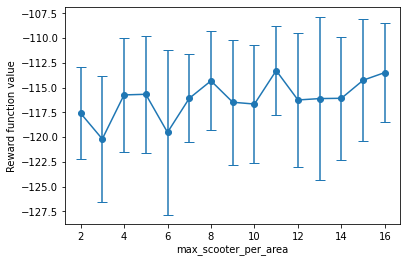

In [64]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_reward_list_grid = np.array([avg_reward_max_2,
                                avg_reward_max_3,
                                avg_reward_max_4,
                                avg_reward_max_5,
                                avg_reward_max_6,
                                avg_reward_max_7,
                                avg_reward_max_8,
                                avg_reward_max_9,
                                avg_reward_max_10,
                                avg_reward_max_11,
                                avg_reward_max_12,
                                avg_reward_max_13,
                                avg_reward_max_14,
                                avg_reward_max_15,
                                avg_reward_max_16])
max_reward_mean_grid = np.mean(max_reward_list_grid, axis=1)
max_reward_std_grid = np.std(max_reward_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_reward_mean_grid, yerr=max_reward_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Reward function value")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [65]:
max_reward_list_grid

array([[-117.98004658, -113.31366705, -119.23692866, -109.04473886,
        -115.05452371, -115.05174924, -115.67884647, -122.45479768,
        -124.27715921, -123.70740042],
       [-109.77592831, -113.43126209, -130.63569776, -119.55727212,
        -128.45854645, -113.58353875, -120.30185149, -122.85029253,
        -119.16275157, -124.14823102],
       [-111.67607201, -111.83341045, -113.72515653, -121.62106431,
        -117.50125143, -109.89701551, -119.16740042, -126.99479768,
        -118.35870278, -106.64117721],
       [-109.29780269, -113.07660258, -108.52432592, -111.96159488,
        -125.83197979, -112.39442817, -113.90980538, -117.01385417,
        -125.98908768, -118.76376929],
       [-108.83577198, -133.61355414, -113.35637203, -124.23637203,
        -126.95167976, -125.61029253, -122.33029253, -114.47029253,
        -120.05029253, -105.76733094],
       [-124.91775927, -109.93824642, -116.03630255, -109.7188899 ,
        -117.23588488, -120.83745924, -113.98076428, -115

End: 2025-07-11 01:48:39
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:39


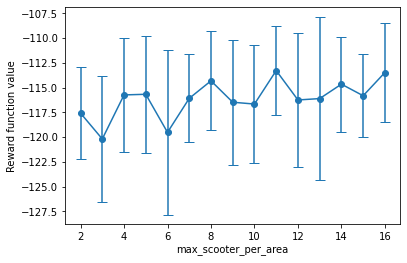

In [66]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_reward_list_grid = [np.array(avg_reward_max_2)[sel_index_2],
                        np.array(avg_reward_max_3)[sel_index_3],
                        np.array(avg_reward_max_4)[sel_index_4],
                        np.array(avg_reward_max_5)[sel_index_5],
                        np.array(avg_reward_max_6)[sel_index_6],
                        np.array(avg_reward_max_7)[sel_index_7],
                        np.array(avg_reward_max_8)[sel_index_8],
                        np.array(avg_reward_max_9)[sel_index_9],
                        np.array(avg_reward_max_10)[sel_index_10],
                        np.array(avg_reward_max_11)[sel_index_11],
                        np.array(avg_reward_max_12)[sel_index_12],
                        np.array(avg_reward_max_13)[sel_index_13],
                        np.array(avg_reward_max_14)[sel_index_14],
                        np.array(avg_reward_max_15)[sel_index_15],
                        np.array(avg_reward_max_16)[sel_index_16]]
max_reward_mean_grid = []
max_reward_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_reward_mean_grid.append(np.mean(max_reward_list_grid[ii]))
    max_reward_std_grid.append(np.std(max_reward_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_reward_mean_grid, yerr=max_reward_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Reward function value")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:39
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:39


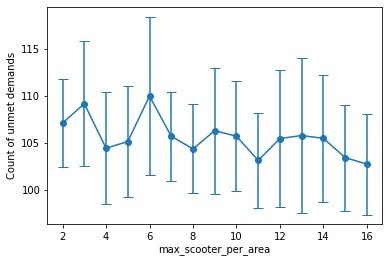

In [67]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_unmet_demand_list_grid = np.array([avg_unmet_demand_max_2,
                                avg_unmet_demand_max_3,
                                avg_unmet_demand_max_4,
                                avg_unmet_demand_max_5,
                                avg_unmet_demand_max_6,
                                avg_unmet_demand_max_7,
                                avg_unmet_demand_max_8,
                                avg_unmet_demand_max_9,
                                avg_unmet_demand_max_10,
                                avg_unmet_demand_max_11,
                                avg_unmet_demand_max_12,
                                avg_unmet_demand_max_13,
                                avg_unmet_demand_max_14,
                                avg_unmet_demand_max_15,
                                avg_unmet_demand_max_16])
max_unmet_demand_mean_grid = np.mean(max_unmet_demand_list_grid, axis=1)
max_unmet_demand_std_grid = np.std(max_unmet_demand_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_unmet_demand_mean_grid, yerr=max_unmet_demand_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of unmet demands")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [68]:
max_unmet_demand_list_grid

array([[106.4, 103.4, 109.8,  97.8, 105.4, 104.6, 105.8, 110.2, 114.6,
        113.2],
       [ 97.8, 102.4, 118.6, 108.6, 119.2, 102.4, 109.2, 112.6, 108. ,
        113. ],
       [101.2, 100.6, 103.8, 111. , 106.6,  97.6, 108.4, 115.2, 105.8,
         94.4],
       [ 97.6, 103.4,  98.4, 100.6, 115.8, 102.4, 103.6, 107.6, 114. ,
        108.2],
       [100. , 124.8, 103.4, 113.8, 118.2, 116. , 112.8, 104.6, 110. ,
         96.2],
       [114.2, 100.4, 105.2,  98. , 106.2, 111. , 103.8, 106. , 110. ,
        102.4],
       [108.2, 105.4, 100.4, 103.8, 104.6,  97.4, 105.6,  96.8, 110.2,
        111.4],
       [ 98.8, 112.2, 103. , 113.2,  97. , 112.8, 112.8, 113.2,  99.8,
        100.4],
       [ 99.8,  96.4, 108.2, 103.6, 104.8,  99.4, 117. , 108.2, 110.8,
        109. ],
       [ 96.2, 103. , 105.4,  93.8, 105. , 106.2, 110. , 103.2, 109.4,
         99.4],
       [113.4, 101. ,  96.8, 104.6, 107.8, 109.8, 120. , 100.8,  94.8,
        105.8],
       [108. ,  96.8, 108.8, 118.4, 102.4, 

End: 2025-07-11 01:48:39
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:39


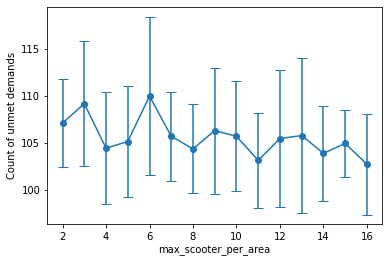

In [69]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_unmet_demand_list_grid = [np.array(avg_unmet_demand_max_2)[sel_index_2],
                        np.array(avg_unmet_demand_max_3)[sel_index_3],
                        np.array(avg_unmet_demand_max_4)[sel_index_4],
                        np.array(avg_unmet_demand_max_5)[sel_index_5],
                        np.array(avg_unmet_demand_max_6)[sel_index_6],
                        np.array(avg_unmet_demand_max_7)[sel_index_7],
                        np.array(avg_unmet_demand_max_8)[sel_index_8],
                        np.array(avg_unmet_demand_max_9)[sel_index_9],
                        np.array(avg_unmet_demand_max_10)[sel_index_10],
                        np.array(avg_unmet_demand_max_11)[sel_index_11],
                        np.array(avg_unmet_demand_max_12)[sel_index_12],
                        np.array(avg_unmet_demand_max_13)[sel_index_13],
                        np.array(avg_unmet_demand_max_14)[sel_index_14],
                        np.array(avg_unmet_demand_max_15)[sel_index_15],
                        np.array(avg_unmet_demand_max_16)[sel_index_16]]
max_unmet_demand_mean_grid = []
max_unmet_demand_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_unmet_demand_mean_grid.append(np.mean(max_unmet_demand_list_grid[ii]))
    max_unmet_demand_std_grid.append(np.std(max_unmet_demand_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_unmet_demand_mean_grid, yerr=max_unmet_demand_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of unmet demands")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:39
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:39


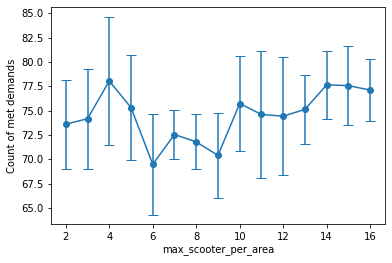

In [70]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_met_demand_list_grid = np.array([avg_met_demand_max_2,
                                avg_met_demand_max_3,
                                avg_met_demand_max_4,
                                avg_met_demand_max_5,
                                avg_met_demand_max_6,
                                avg_met_demand_max_7,
                                avg_met_demand_max_8,
                                avg_met_demand_max_9,
                                avg_met_demand_max_10,
                                avg_met_demand_max_11,
                                avg_met_demand_max_12,
                                avg_met_demand_max_13,
                                avg_met_demand_max_14,
                                avg_met_demand_max_15,
                                avg_met_demand_max_16])
max_met_demand_mean_grid = np.mean(max_met_demand_list_grid, axis=1)
max_met_demand_std_grid = np.std(max_met_demand_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_met_demand_mean_grid, yerr=max_met_demand_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of met demands")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [71]:
max_met_demand_list_grid

array([[73.2, 75. , 69.8, 83.6, 68.8, 70.2, 70.2, 75.6, 70.4, 79.2],
       [76.8, 72. , 85.2, 76.2, 64.8, 69.4, 77. , 74.2, 71.2, 74.8],
       [77.6, 73.4, 74.8, 81.6, 72. , 87. , 72.4, 68.4, 87. , 86.2],
       [79.8, 73.4, 76. , 87.2, 67.6, 78.2, 71.6, 68.8, 76.6, 73.8],
       [77.8, 70.8, 68.2, 64.8, 68. , 63.4, 67.8, 67.6, 66.2, 80.2],
       [74.2, 70.4, 74.6, 74. , 72. , 72.6, 72.8, 76.4, 66.8, 71.6],
       [75.2, 70.2, 70.2, 70.8, 77. , 71.2, 70.8, 71.4, 74.4, 66.6],
       [72.8, 61.8, 75.4, 69.2, 75. , 70.2, 67. , 68. , 68. , 76.6],
       [83.6, 83.4, 78. , 74.2, 78.2, 69. , 76.2, 71.4, 72.2, 71. ],
       [84.4, 71.8, 74.4, 89. , 71. , 68.2, 67.2, 71.8, 73.8, 74.4],
       [75.6, 85.8, 72.8, 72.6, 73.8, 77. , 64.2, 68. , 82.6, 71.8],
       [72.2, 78. , 73.8, 71.8, 68.6, 76. , 78.6, 76.6, 74.2, 81.4],
       [77.6, 75.2, 77.2, 81. , 77. , 78.2, 69.4, 80.2, 83. , 77.6],
       [82.6, 77. , 70.4, 76.4, 76.6, 73.6, 74.6, 78.4, 83.2, 82.8],
       [76. , 76.2, 70.8, 75. , 77

End: 2025-07-11 01:48:39
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:39


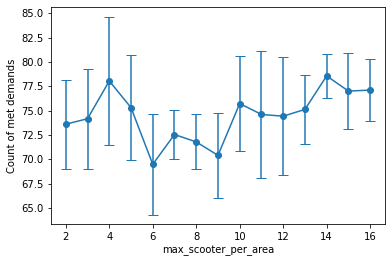

In [72]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_met_demand_list_grid = [np.array(avg_met_demand_max_2)[sel_index_2],
                        np.array(avg_met_demand_max_3)[sel_index_3],
                        np.array(avg_met_demand_max_4)[sel_index_4],
                        np.array(avg_met_demand_max_5)[sel_index_5],
                        np.array(avg_met_demand_max_6)[sel_index_6],
                        np.array(avg_met_demand_max_7)[sel_index_7],
                        np.array(avg_met_demand_max_8)[sel_index_8],
                        np.array(avg_met_demand_max_9)[sel_index_9],
                        np.array(avg_met_demand_max_10)[sel_index_10],
                        np.array(avg_met_demand_max_11)[sel_index_11],
                        np.array(avg_met_demand_max_12)[sel_index_12],
                        np.array(avg_met_demand_max_13)[sel_index_13],
                        np.array(avg_met_demand_max_14)[sel_index_14],
                        np.array(avg_met_demand_max_15)[sel_index_15],
                        np.array(avg_met_demand_max_16)[sel_index_16]]
max_met_demand_mean_grid = []
max_met_demand_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_met_demand_mean_grid.append(np.mean(max_met_demand_list_grid[ii]))
    max_met_demand_std_grid.append(np.std(max_met_demand_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_met_demand_mean_grid, yerr=max_met_demand_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of met demands")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:40
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:40


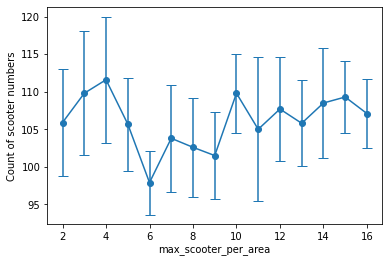

In [73]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_scooter_num_list_grid = np.array([avg_scooter_num_max_2,
                                avg_scooter_num_max_3,
                                avg_scooter_num_max_4,
                                avg_scooter_num_max_5,
                                avg_scooter_num_max_6,
                                avg_scooter_num_max_7,
                                avg_scooter_num_max_8,
                                avg_scooter_num_max_9,
                                avg_scooter_num_max_10,
                                avg_scooter_num_max_11,
                                avg_scooter_num_max_12,
                                avg_scooter_num_max_13,
                                avg_scooter_num_max_14,
                                avg_scooter_num_max_15,
                                avg_scooter_num_max_16])
max_scooter_num_mean_grid = np.mean(max_scooter_num_list_grid, axis=1)
max_scooter_num_std_grid = np.std(max_scooter_num_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_scooter_num_mean_grid, yerr=max_scooter_num_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of scooter numbers")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [74]:
max_scooter_num_list_grid

array([[114., 104.,  98., 120., 102., 100., 102., 113.,  98., 108.],
       [122., 108., 122., 112.,  99., 108., 104.,  96., 113., 114.],
       [100., 112., 109., 109.,  98., 120., 108., 113., 124., 123.],
       [115., 103., 103., 112., 100., 107., 104.,  93., 112., 108.],
       [ 97.,  90., 103., 103.,  97.,  96.,  96.,  96.,  96., 105.],
       [104.,  96., 100., 113., 111., 101., 106., 100.,  92., 115.],
       [102.,  93.,  98.,  94., 115., 108., 106., 104.,  98., 108.],
       [114.,  97.,  99., 101.,  99.,  98.,  98.,  96., 102., 111.],
       [111., 111., 117., 117., 117., 105., 105., 105., 105., 105.],
       [115., 106., 102., 130., 100.,  99., 100., 100.,  99.,  99.],
       [105., 114., 115., 100., 105., 117.,  93., 107., 110., 111.],
       [107., 105., 112., 103.,  95., 111., 110., 104.,  98., 113.],
       [110., 107., 104., 100., 112., 119.,  94., 108., 118., 113.],
       [113., 112., 105., 108., 109., 103., 116., 102., 109., 116.],
       [105., 108., 100., 102., 10

End: 2025-07-11 01:48:40
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:40


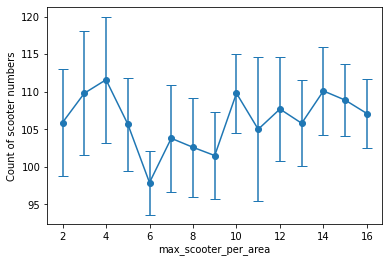

In [75]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_scooter_num_list_grid = [np.array(avg_scooter_num_max_2)[sel_index_2],
                        np.array(avg_scooter_num_max_3)[sel_index_3],
                        np.array(avg_scooter_num_max_4)[sel_index_4],
                        np.array(avg_scooter_num_max_5)[sel_index_5],
                        np.array(avg_scooter_num_max_6)[sel_index_6],
                        np.array(avg_scooter_num_max_7)[sel_index_7],
                        np.array(avg_scooter_num_max_8)[sel_index_8],
                        np.array(avg_scooter_num_max_9)[sel_index_9],
                        np.array(avg_scooter_num_max_10)[sel_index_10],
                        np.array(avg_scooter_num_max_11)[sel_index_11],
                        np.array(avg_scooter_num_max_12)[sel_index_12],
                        np.array(avg_scooter_num_max_13)[sel_index_13],
                        np.array(avg_scooter_num_max_14)[sel_index_14],
                        np.array(avg_scooter_num_max_15)[sel_index_15],
                        np.array(avg_scooter_num_max_16)[sel_index_16]]
max_scooter_num_mean_grid = []
max_scooter_num_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_scooter_num_mean_grid.append(np.mean(max_scooter_num_list_grid[ii]))
    max_scooter_num_std_grid.append(np.std(max_scooter_num_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_scooter_num_mean_grid, yerr=max_scooter_num_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of scooter numbers")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:40
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:40


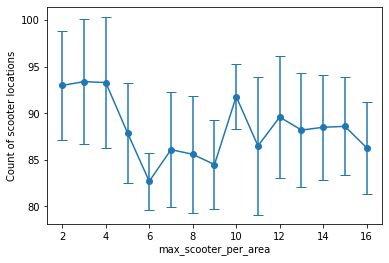

In [76]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_scooter_loc_list_grid = np.array([avg_scooter_loc_max_2,
                                avg_scooter_loc_max_3,
                                avg_scooter_loc_max_4,
                                avg_scooter_loc_max_5,
                                avg_scooter_loc_max_6,
                                avg_scooter_loc_max_7,
                                avg_scooter_loc_max_8,
                                avg_scooter_loc_max_9,
                                avg_scooter_loc_max_10,
                                avg_scooter_loc_max_11,
                                avg_scooter_loc_max_12,
                                avg_scooter_loc_max_13,
                                avg_scooter_loc_max_14,
                                avg_scooter_loc_max_15,
                                avg_scooter_loc_max_16])
max_scooter_loc_mean_grid = np.mean(max_scooter_loc_list_grid, axis=1)
max_scooter_loc_std_grid = np.std(max_scooter_loc_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_scooter_loc_mean_grid, yerr=max_scooter_loc_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of scooter locations")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [77]:
max_scooter_loc_list_grid

array([[100,  91,  88, 104,  95,  91,  88,  95,  83,  95],
       [ 99,  98, 104,  96,  85,  92,  87,  81,  96,  96],
       [ 84,  93,  89,  91,  81,  98,  95,  95, 103, 104],
       [ 94,  82,  88,  89,  86,  84,  88,  81, 100,  87],
       [ 81,  78,  87,  87,  83,  81,  81,  81,  81,  87],
       [ 89,  82,  79,  93,  94,  86,  88,  82,  75,  93],
       [ 83,  80,  79,  76,  97,  92,  92,  87,  83,  87],
       [ 95,  81,  85,  84,  80,  78,  85,  81,  86,  90],
       [ 91,  91,  97,  97,  97,  89,  89,  89,  89,  89],
       [ 91,  88,  84, 106,  82,  80,  88,  84,  80,  82],
       [ 89,  96,  99,  81,  85,  95,  78,  87,  91,  95],
       [ 85,  86, 101,  91,  79,  94,  89,  85,  81,  91],
       [ 92,  86,  83,  87,  85,  98,  78,  89,  95,  92],
       [ 94,  85,  87,  89,  90,  81,  94,  80,  89,  97],
       [ 86,  92,  81,  81,  81,  84,  90,  94,  92,  82]])

End: 2025-07-11 01:48:40
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:40


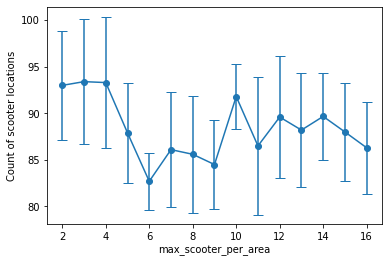

In [78]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_scooter_loc_list_grid = [np.array(avg_scooter_loc_max_2)[sel_index_2],
                        np.array(avg_scooter_loc_max_3)[sel_index_3],
                        np.array(avg_scooter_loc_max_4)[sel_index_4],
                        np.array(avg_scooter_loc_max_5)[sel_index_5],
                        np.array(avg_scooter_loc_max_6)[sel_index_6],
                        np.array(avg_scooter_loc_max_7)[sel_index_7],
                        np.array(avg_scooter_loc_max_8)[sel_index_8],
                        np.array(avg_scooter_loc_max_9)[sel_index_9],
                        np.array(avg_scooter_loc_max_10)[sel_index_10],
                        np.array(avg_scooter_loc_max_11)[sel_index_11],
                        np.array(avg_scooter_loc_max_12)[sel_index_12],
                        np.array(avg_scooter_loc_max_13)[sel_index_13],
                        np.array(avg_scooter_loc_max_14)[sel_index_14],
                        np.array(avg_scooter_loc_max_15)[sel_index_15],
                        np.array(avg_scooter_loc_max_16)[sel_index_16]]
max_scooter_loc_mean_grid = []
max_scooter_loc_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_scooter_loc_mean_grid.append(np.mean(max_scooter_loc_list_grid[ii]))
    max_scooter_loc_std_grid.append(np.std(max_scooter_loc_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_scooter_loc_mean_grid, yerr=max_scooter_loc_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Count of scooter locations")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:40
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:40


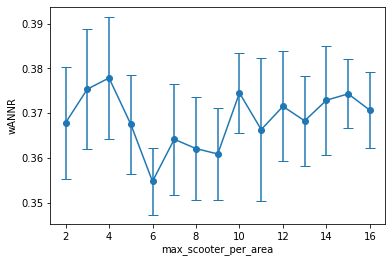

In [79]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_wANNR_list_grid = np.array([avg_wANNR_max_2,
                                avg_wANNR_max_3,
                                avg_wANNR_max_4,
                                avg_wANNR_max_5,
                                avg_wANNR_max_6,
                                avg_wANNR_max_7,
                                avg_wANNR_max_8,
                                avg_wANNR_max_9,
                                avg_wANNR_max_10,
                                avg_wANNR_max_11,
                                avg_wANNR_max_12,
                                avg_wANNR_max_13,
                                avg_wANNR_max_14,
                                avg_wANNR_max_15,
                                avg_wANNR_max_16])
max_wANNR_mean_grid = np.mean(max_wANNR_list_grid, axis=1)
max_wANNR_std_grid = np.std(max_wANNR_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_wANNR_mean_grid, yerr=max_wANNR_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("wANNR")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [80]:
max_wANNR_list_grid

array([[0.38311658, 0.36460861, 0.35392432, 0.3916386 , 0.36107415,
        0.35750563, 0.36107466, 0.38006665, 0.3539243 , 0.37154245],
       [0.39488859, 0.37153069, 0.39488812, 0.37837042, 0.36290081,
        0.37298588, 0.36459685, 0.35029439, 0.38005522, 0.38310619],
       [0.36195728, 0.37835954, 0.37324687, 0.37325816, 0.35392449,
        0.39162798, 0.37154202, 0.38004481, 0.39811186, 0.39649295],
       [0.38338235, 0.36285157, 0.36284006, 0.37838141, 0.35751754,
        0.36981805, 0.36458571, 0.34477837, 0.3797772 , 0.37153078],
       [0.3557442 , 0.33915992, 0.36284008, 0.36284008, 0.35362615,
        0.35181383, 0.35181383, 0.35181383, 0.35181383, 0.36635726],
       [0.36460855, 0.35029456, 0.35752899, 0.38004467, 0.37665524,
        0.35928892, 0.36810875, 0.35900585, 0.34290778, 0.38339289],
       [0.36106326, 0.34479046, 0.35392481, 0.348198  , 0.3833931 ,
        0.37153064, 0.3680859 , 0.36459692, 0.35392448, 0.37156416],
       [0.38171197, 0.35212589, 0.3557253

End: 2025-07-11 01:48:40
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:40


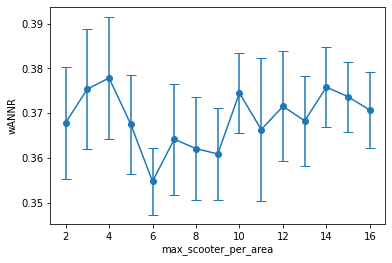

In [81]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_wANNR_list_grid = [np.array(avg_wANNR_max_2)[sel_index_2],
                        np.array(avg_wANNR_max_3)[sel_index_3],
                        np.array(avg_wANNR_max_4)[sel_index_4],
                        np.array(avg_wANNR_max_5)[sel_index_5],
                        np.array(avg_wANNR_max_6)[sel_index_6],
                        np.array(avg_wANNR_max_7)[sel_index_7],
                        np.array(avg_wANNR_max_8)[sel_index_8],
                        np.array(avg_wANNR_max_9)[sel_index_9],
                        np.array(avg_wANNR_max_10)[sel_index_10],
                        np.array(avg_wANNR_max_11)[sel_index_11],
                        np.array(avg_wANNR_max_12)[sel_index_12],
                        np.array(avg_wANNR_max_13)[sel_index_13],
                        np.array(avg_wANNR_max_14)[sel_index_14],
                        np.array(avg_wANNR_max_15)[sel_index_15],
                        np.array(avg_wANNR_max_16)[sel_index_16]]
max_wANNR_mean_grid = []
max_wANNR_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_wANNR_mean_grid.append(np.mean(max_wANNR_list_grid[ii]))
    max_wANNR_std_grid.append(np.std(max_wANNR_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_wANNR_mean_grid, yerr=max_wANNR_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("wANNR")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:40
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:40


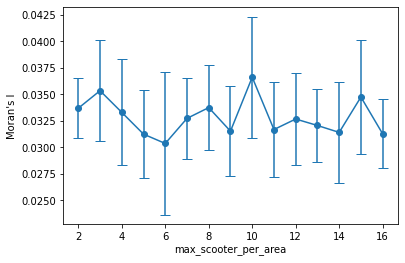

In [82]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_moran_list_grid = np.array([avg_moran_max_2,
                                avg_moran_max_3,
                                avg_moran_max_4,
                                avg_moran_max_5,
                                avg_moran_max_6,
                                avg_moran_max_7,
                                avg_moran_max_8,
                                avg_moran_max_9,
                                avg_moran_max_10,
                                avg_moran_max_11,
                                avg_moran_max_12,
                                avg_moran_max_13,
                                avg_moran_max_14,
                                avg_moran_max_15,
                                avg_moran_max_16])
max_moran_mean_grid = np.mean(max_moran_list_grid, axis=1)
max_moran_std_grid = np.std(max_moran_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_moran_mean_grid, yerr=max_moran_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Moran's I")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [83]:
max_moran_list_grid

array([[0.03373686, 0.03762052, 0.03794394, 0.03165344, 0.029234  ,
        0.02947343, 0.03373018, 0.03332019, 0.03555859, 0.03468249],
       [0.04228144, 0.03652112, 0.04155162, 0.03267132, 0.03015543,
        0.03780386, 0.02581596, 0.03568365, 0.03725618, 0.03375057],
       [0.03627919, 0.03459063, 0.04152439, 0.03356386, 0.0210475 ,
        0.03652432, 0.03134561, 0.03144531, 0.03206513, 0.03467378],
       [0.03569748, 0.02741858, 0.03222669, 0.03748749, 0.02894564,
        0.03771414, 0.03104659, 0.02823547, 0.02627348, 0.02747968],
       [0.03527618, 0.03719219, 0.02499033, 0.02499033, 0.0308509 ,
        0.02608082, 0.02608082, 0.02608082, 0.02608082, 0.04608385],
       [0.03673732, 0.03728332, 0.03074435, 0.03628422, 0.02750526,
        0.03520248, 0.03068464, 0.03113846, 0.03554209, 0.02625632],
       [0.03937877, 0.02684289, 0.03537052, 0.03080831, 0.03115934,
        0.03509985, 0.03742939, 0.03137012, 0.03949057, 0.03061118],
       [0.03490058, 0.02358462, 0.0321581

End: 2025-07-11 01:48:40
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:40


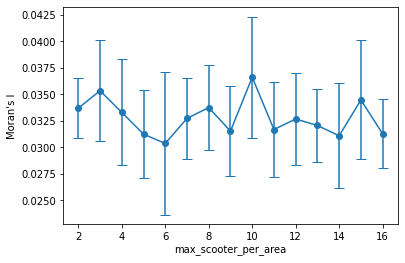

In [84]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_moran_list_grid = [np.array(avg_moran_max_2)[sel_index_2],
                        np.array(avg_moran_max_3)[sel_index_3],
                        np.array(avg_moran_max_4)[sel_index_4],
                        np.array(avg_moran_max_5)[sel_index_5],
                        np.array(avg_moran_max_6)[sel_index_6],
                        np.array(avg_moran_max_7)[sel_index_7],
                        np.array(avg_moran_max_8)[sel_index_8],
                        np.array(avg_moran_max_9)[sel_index_9],
                        np.array(avg_moran_max_10)[sel_index_10],
                        np.array(avg_moran_max_11)[sel_index_11],
                        np.array(avg_moran_max_12)[sel_index_12],
                        np.array(avg_moran_max_13)[sel_index_13],
                        np.array(avg_moran_max_14)[sel_index_14],
                        np.array(avg_moran_max_15)[sel_index_15],
                        np.array(avg_moran_max_16)[sel_index_16]]
max_moran_mean_grid = []
max_moran_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_moran_mean_grid.append(np.mean(max_moran_list_grid[ii]))
    max_moran_std_grid.append(np.std(max_moran_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_moran_mean_grid, yerr=max_moran_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Moran's I")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:40
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:40


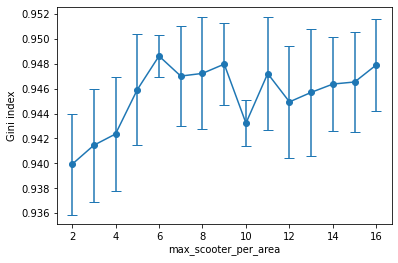

In [85]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_gini_list_grid = np.array([avg_gini_max_2,
                                avg_gini_max_3,
                                avg_gini_max_4,
                                avg_gini_max_5,
                                avg_gini_max_6,
                                avg_gini_max_7,
                                avg_gini_max_8,
                                avg_gini_max_9,
                                avg_gini_max_10,
                                avg_gini_max_11,
                                avg_gini_max_12,
                                avg_gini_max_13,
                                avg_gini_max_14,
                                avg_gini_max_15,
                                avg_gini_max_16])
max_gini_mean_grid = np.mean(max_gini_list_grid, axis=1)
max_gini_std_grid = np.std(max_gini_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_gini_mean_grid, yerr=max_gini_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Gini index")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [86]:
max_gini_list_grid

array([[0.93556297, 0.94146253, 0.9423337 , 0.93352546, 0.93590721,
        0.93975504, 0.94391705, 0.940393  , 0.9477004 , 0.93866741],
       [0.94020173, 0.93547871, 0.93441442, 0.93957132, 0.94618374,
        0.94234977, 0.94614553, 0.94961275, 0.94029099, 0.94027757],
       [0.94801153, 0.9428134 , 0.94567459, 0.94427332, 0.95028818,
        0.94045389, 0.93896093, 0.94099232, 0.93677373, 0.93535179],
       [0.94307104, 0.95154724, 0.94501413, 0.94705897, 0.94564841,
        0.95040938, 0.94524496, 0.94836695, 0.93474681, 0.94806009],
       [0.95039217, 0.9504643 , 0.94609132, 0.94609132, 0.94801539,
        0.94964277, 0.94964277, 0.94964277, 0.94964277, 0.9466104 ],
       [0.94406728, 0.94842699, 0.95301153, 0.94295606, 0.94144793,
        0.94630781, 0.94559839, 0.94987032, 0.95415675, 0.9442739 ],
       [0.95021755, 0.94993183, 0.95234664, 0.95393648, 0.93976319,
        0.94237645, 0.9413164 , 0.94667202, 0.94808269, 0.94763315],
       [0.94128874, 0.95013963, 0.9465767

End: 2025-07-11 01:48:41
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:41


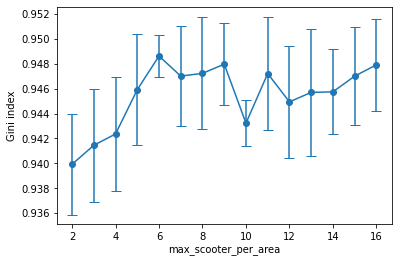

In [87]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_gini_list_grid = [np.array(avg_gini_max_2)[sel_index_2],
                        np.array(avg_gini_max_3)[sel_index_3],
                        np.array(avg_gini_max_4)[sel_index_4],
                        np.array(avg_gini_max_5)[sel_index_5],
                        np.array(avg_gini_max_6)[sel_index_6],
                        np.array(avg_gini_max_7)[sel_index_7],
                        np.array(avg_gini_max_8)[sel_index_8],
                        np.array(avg_gini_max_9)[sel_index_9],
                        np.array(avg_gini_max_10)[sel_index_10],
                        np.array(avg_gini_max_11)[sel_index_11],
                        np.array(avg_gini_max_12)[sel_index_12],
                        np.array(avg_gini_max_13)[sel_index_13],
                        np.array(avg_gini_max_14)[sel_index_14],
                        np.array(avg_gini_max_15)[sel_index_15],
                        np.array(avg_gini_max_16)[sel_index_16]]
max_gini_mean_grid = []
max_gini_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_gini_mean_grid.append(np.mean(max_gini_list_grid[ii]))
    max_gini_std_grid.append(np.std(max_gini_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_gini_mean_grid, yerr=max_gini_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Gini index")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:41
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:41


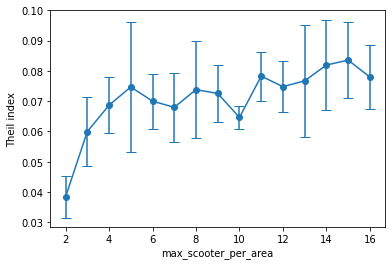

In [88]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_theil_list_grid = np.array([avg_theil_max_2,
                                avg_theil_max_3,
                                avg_theil_max_4,
                                avg_theil_max_5,
                                avg_theil_max_6,
                                avg_theil_max_7,
                                avg_theil_max_8,
                                avg_theil_max_9,
                                avg_theil_max_10,
                                avg_theil_max_11,
                                avg_theil_max_12,
                                avg_theil_max_13,
                                avg_theil_max_14,
                                avg_theil_max_15,
                                avg_theil_max_16])
max_theil_mean_grid = np.mean(max_theil_list_grid, axis=1)
max_theil_std_grid = np.std(max_theil_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_theil_mean_grid, yerr=max_theil_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Theil index")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [89]:
max_theil_list_grid

array([[0.03921841, 0.0397554 , 0.03382794, 0.0417384 , 0.02404193,
        0.03045581, 0.0426397 , 0.04731472, 0.04606104, 0.03861443],
       [0.0781829 , 0.04088662, 0.04919401, 0.05790695, 0.04885837,
        0.05956896, 0.06321672, 0.06306096, 0.07793153, 0.06080801],
       [0.06838364, 0.06796299, 0.06605575, 0.08827889, 0.06944644,
        0.07343171, 0.04830421, 0.06421333, 0.0730621 , 0.06761982],
       [0.08176673, 0.10517046, 0.07319476, 0.08892192, 0.05372328,
        0.09166886, 0.0663469 , 0.051979  , 0.03520285, 0.09902675],
       [0.09128037, 0.05336614, 0.07522523, 0.07522523, 0.06929367,
        0.06660052, 0.06660052, 0.06660052, 0.06660052, 0.06953149],
       [0.05928547, 0.05543999, 0.08156189, 0.06446505, 0.06493572,
        0.06919912, 0.0591788 , 0.06677949, 0.06323758, 0.09578283],
       [0.10227805, 0.0906463 , 0.0746088 , 0.06959859, 0.06791876,
        0.06271524, 0.04638127, 0.08987623, 0.05673958, 0.07755858],
       [0.06249719, 0.07698868, 0.0647143

End: 2025-07-11 01:48:41
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:41


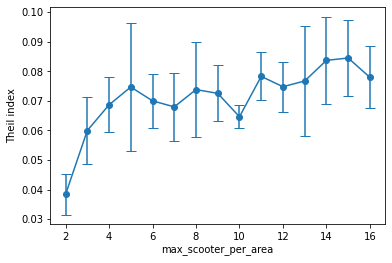

In [90]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_theil_list_grid = [np.array(avg_theil_max_2)[sel_index_2],
                        np.array(avg_theil_max_3)[sel_index_3],
                        np.array(avg_theil_max_4)[sel_index_4],
                        np.array(avg_theil_max_5)[sel_index_5],
                        np.array(avg_theil_max_6)[sel_index_6],
                        np.array(avg_theil_max_7)[sel_index_7],
                        np.array(avg_theil_max_8)[sel_index_8],
                        np.array(avg_theil_max_9)[sel_index_9],
                        np.array(avg_theil_max_10)[sel_index_10],
                        np.array(avg_theil_max_11)[sel_index_11],
                        np.array(avg_theil_max_12)[sel_index_12],
                        np.array(avg_theil_max_13)[sel_index_13],
                        np.array(avg_theil_max_14)[sel_index_14],
                        np.array(avg_theil_max_15)[sel_index_15],
                        np.array(avg_theil_max_16)[sel_index_16]]
max_theil_mean_grid = []
max_theil_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_theil_mean_grid.append(np.mean(max_theil_list_grid[ii]))
    max_theil_std_grid.append(np.std(max_theil_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_theil_mean_grid, yerr=max_theil_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Theil index")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:41
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:41


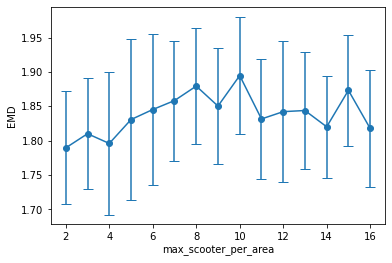

In [91]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_EMD_list_grid = np.array([avg_EMD_max_2,
                                avg_EMD_max_3,
                                avg_EMD_max_4,
                                avg_EMD_max_5,
                                avg_EMD_max_6,
                                avg_EMD_max_7,
                                avg_EMD_max_8,
                                avg_EMD_max_9,
                                avg_EMD_max_10,
                                avg_EMD_max_11,
                                avg_EMD_max_12,
                                avg_EMD_max_13,
                                avg_EMD_max_14,
                                avg_EMD_max_15,
                                avg_EMD_max_16])
max_EMD_mean_grid = np.mean(max_EMD_list_grid, axis=1)
max_EMD_std_grid = np.std(max_EMD_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_EMD_mean_grid, yerr=max_EMD_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("EMD")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [92]:
max_EMD_list_grid

array([[1.71895624, 1.80695687, 1.89837158, 1.65781166, 1.71752554,
        1.800641  , 1.86020568, 1.76260749, 1.93070148, 1.74042845],
       [1.80575735, 1.84721037, 1.81257083, 1.76098658, 1.71424082,
        1.84804707, 1.76086204, 1.95191827, 1.91645316, 1.68203511],
       [1.87102379, 1.93435653, 1.98832828, 1.83658999, 1.67851298,
        1.78482906, 1.66064375, 1.73150846, 1.74228409, 1.730084  ],
       [1.93852938, 1.88545189, 1.87887639, 1.93400472, 1.77560116,
        1.96557104, 1.82323735, 1.75913692, 1.54414133, 1.8014873 ],
       [2.00186301, 1.92020253, 1.73873409, 1.73873409, 1.74182571,
        1.80911957, 1.80911957, 1.80911957, 1.80911957, 2.07447177],
       [1.85954852, 2.0306338 , 1.8758766 , 1.909169  , 1.77076715,
        1.87328505, 1.70288811, 1.8881841 , 1.90689952, 1.765315  ],
       [2.01875113, 1.8426669 , 1.9353418 , 1.89634581, 1.70261199,
        1.85549521, 1.80457562, 1.90617699, 1.971664  , 1.85995593],
       [1.76030453, 1.73615682, 1.8207041

End: 2025-07-11 01:48:41
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:41


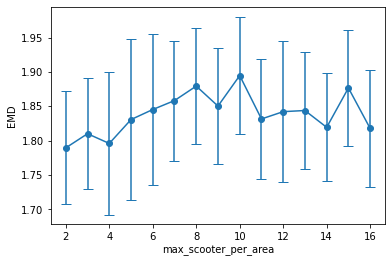

In [93]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_EMD_list_grid = [np.array(avg_EMD_max_2)[sel_index_2],
                        np.array(avg_EMD_max_3)[sel_index_3],
                        np.array(avg_EMD_max_4)[sel_index_4],
                        np.array(avg_EMD_max_5)[sel_index_5],
                        np.array(avg_EMD_max_6)[sel_index_6],
                        np.array(avg_EMD_max_7)[sel_index_7],
                        np.array(avg_EMD_max_8)[sel_index_8],
                        np.array(avg_EMD_max_9)[sel_index_9],
                        np.array(avg_EMD_max_10)[sel_index_10],
                        np.array(avg_EMD_max_11)[sel_index_11],
                        np.array(avg_EMD_max_12)[sel_index_12],
                        np.array(avg_EMD_max_13)[sel_index_13],
                        np.array(avg_EMD_max_14)[sel_index_14],
                        np.array(avg_EMD_max_15)[sel_index_15],
                        np.array(avg_EMD_max_16)[sel_index_16]]
max_EMD_mean_grid = []
max_EMD_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_EMD_mean_grid.append(np.mean(max_EMD_list_grid[ii]))
    max_EMD_std_grid.append(np.std(max_EMD_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_EMD_mean_grid, yerr=max_EMD_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("EMD")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:41
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:41


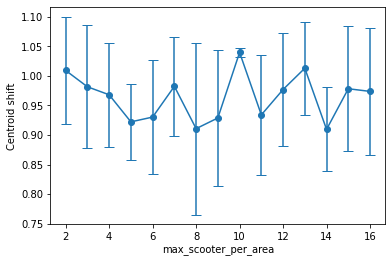

In [94]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_centroid_list_grid = np.array([avg_centroid_max_2,
                                avg_centroid_max_3,
                                avg_centroid_max_4,
                                avg_centroid_max_5,
                                avg_centroid_max_6,
                                avg_centroid_max_7,
                                avg_centroid_max_8,
                                avg_centroid_max_9,
                                avg_centroid_max_10,
                                avg_centroid_max_11,
                                avg_centroid_max_12,
                                avg_centroid_max_13,
                                avg_centroid_max_14,
                                avg_centroid_max_15,
                                avg_centroid_max_16])
max_centroid_mean_grid = np.mean(max_centroid_list_grid, axis=1)
max_centroid_std_grid = np.std(max_centroid_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_centroid_mean_grid, yerr=max_centroid_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Centroid shift")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [95]:
max_centroid_list_grid

array([[1.09717937, 1.00818957, 1.02912589, 1.0687124 , 1.00872712,
        1.17587463, 1.02512101, 0.86833426, 0.88095246, 0.93002101],
       [0.93645037, 0.96610721, 1.06050589, 1.10261346, 0.72082154,
        1.04440502, 1.07457415, 0.96559852, 1.01753641, 0.92695981],
       [0.86577491, 1.05106175, 1.14272243, 0.91097698, 1.01016652,
        0.92675959, 0.85013514, 0.89990487, 0.99742289, 1.02522989],
       [0.88116553, 0.8517277 , 1.00569638, 0.88427564, 0.85573464,
        1.03452003, 0.86672808, 0.9030709 , 0.94379121, 0.99514034],
       [0.92113067, 0.99354553, 0.92010081, 0.92010081, 0.6702087 ,
        0.99976525, 0.99976525, 0.99976525, 0.99976525, 0.87882209],
       [0.92713805, 1.01804342, 0.88119332, 1.0301056 , 1.09365205,
        0.99750693, 0.81038683, 1.00093707, 0.98152151, 1.08292107],
       [0.82700827, 0.7360912 , 0.65033444, 1.04281322, 0.8748338 ,
        1.14021357, 0.92404416, 1.01656791, 0.84670425, 1.04835437],
       [0.75236714, 0.82515407, 0.8963828

End: 2025-07-11 01:48:41
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:41


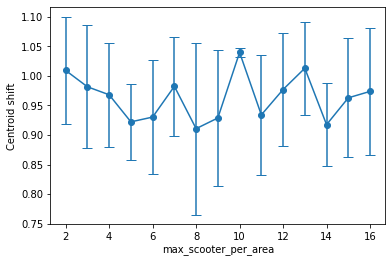

In [96]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_centroid_list_grid = [np.array(avg_centroid_max_2)[sel_index_2],
                        np.array(avg_centroid_max_3)[sel_index_3],
                        np.array(avg_centroid_max_4)[sel_index_4],
                        np.array(avg_centroid_max_5)[sel_index_5],
                        np.array(avg_centroid_max_6)[sel_index_6],
                        np.array(avg_centroid_max_7)[sel_index_7],
                        np.array(avg_centroid_max_8)[sel_index_8],
                        np.array(avg_centroid_max_9)[sel_index_9],
                        np.array(avg_centroid_max_10)[sel_index_10],
                        np.array(avg_centroid_max_11)[sel_index_11],
                        np.array(avg_centroid_max_12)[sel_index_12],
                        np.array(avg_centroid_max_13)[sel_index_13],
                        np.array(avg_centroid_max_14)[sel_index_14],
                        np.array(avg_centroid_max_15)[sel_index_15],
                        np.array(avg_centroid_max_16)[sel_index_16]]
max_centroid_mean_grid = []
max_centroid_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_centroid_mean_grid.append(np.mean(max_centroid_list_grid[ii]))
    max_centroid_std_grid.append(np.std(max_centroid_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_centroid_mean_grid, yerr=max_centroid_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Centroid shift")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:41
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:41


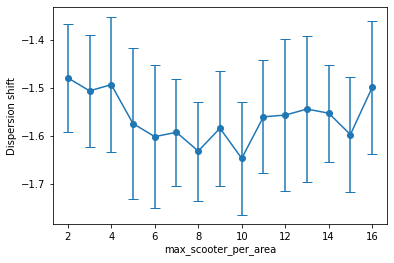

In [97]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_dispersion_list_grid = np.array([avg_dispersion_max_2,
                                avg_dispersion_max_3,
                                avg_dispersion_max_4,
                                avg_dispersion_max_5,
                                avg_dispersion_max_6,
                                avg_dispersion_max_7,
                                avg_dispersion_max_8,
                                avg_dispersion_max_9,
                                avg_dispersion_max_10,
                                avg_dispersion_max_11,
                                avg_dispersion_max_12,
                                avg_dispersion_max_13,
                                avg_dispersion_max_14,
                                avg_dispersion_max_15,
                                avg_dispersion_max_16])
max_dispersion_mean_grid = np.mean(max_dispersion_list_grid, axis=1)
max_dispersion_std_grid = np.std(max_dispersion_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_dispersion_mean_grid, yerr=max_dispersion_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Dispersion shift")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [98]:
max_dispersion_list_grid

array([[-1.3512747 , -1.40988754, -1.60781581, -1.32749012, -1.48478333,
        -1.49078161, -1.59183593, -1.46526446, -1.68787566, -1.37223742],
       [-1.44713566, -1.59815383, -1.51306127, -1.37097112, -1.41030418,
        -1.53374814, -1.45124051, -1.71758677, -1.66438462, -1.35439942],
       [-1.51571528, -1.65874429, -1.75347015, -1.55328768, -1.27278836,
        -1.52935631, -1.27970273, -1.42258773, -1.47162235, -1.47422086],
       [-1.7359745 , -1.68108148, -1.66038801, -1.70537137, -1.50591384,
        -1.67229935, -1.63255619, -1.4826168 , -1.18272238, -1.48566457],
       [-1.80427926, -1.64573668, -1.4550462 , -1.4550462 , -1.41127027,
        -1.58233524, -1.58233524, -1.58233524, -1.58233524, -1.91627352],
       [-1.6203664 , -1.81714317, -1.65945305, -1.61253534, -1.49144958,
        -1.5835428 , -1.44496725, -1.69317974, -1.57277554, -1.43083254],
       [-1.78093514, -1.60615405, -1.70801368, -1.60267054, -1.43801891,
        -1.51565764, -1.55994875, -1.71597182

End: 2025-07-11 01:48:41
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:41


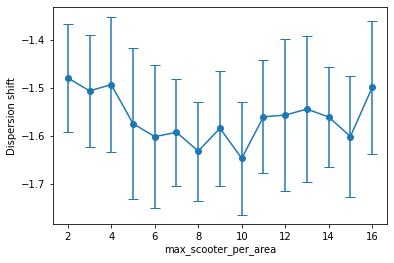

In [99]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_dispersion_list_grid = [np.array(avg_dispersion_max_2)[sel_index_2],
                        np.array(avg_dispersion_max_3)[sel_index_3],
                        np.array(avg_dispersion_max_4)[sel_index_4],
                        np.array(avg_dispersion_max_5)[sel_index_5],
                        np.array(avg_dispersion_max_6)[sel_index_6],
                        np.array(avg_dispersion_max_7)[sel_index_7],
                        np.array(avg_dispersion_max_8)[sel_index_8],
                        np.array(avg_dispersion_max_9)[sel_index_9],
                        np.array(avg_dispersion_max_10)[sel_index_10],
                        np.array(avg_dispersion_max_11)[sel_index_11],
                        np.array(avg_dispersion_max_12)[sel_index_12],
                        np.array(avg_dispersion_max_13)[sel_index_13],
                        np.array(avg_dispersion_max_14)[sel_index_14],
                        np.array(avg_dispersion_max_15)[sel_index_15],
                        np.array(avg_dispersion_max_16)[sel_index_16]]
max_dispersion_mean_grid = []
max_dispersion_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_dispersion_mean_grid.append(np.mean(max_dispersion_list_grid[ii]))
    max_dispersion_std_grid.append(np.std(max_dispersion_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_dispersion_mean_grid, yerr=max_dispersion_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Dispersion shift")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-11 01:48:42
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:42


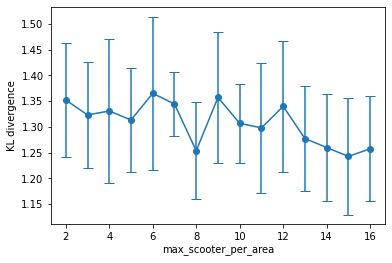

In [100]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_kl_list_grid = np.array([avg_kl_max_2,
                                avg_kl_max_3,
                                avg_kl_max_4,
                                avg_kl_max_5,
                                avg_kl_max_6,
                                avg_kl_max_7,
                                avg_kl_max_8,
                                avg_kl_max_9,
                                avg_kl_max_10,
                                avg_kl_max_11,
                                avg_kl_max_12,
                                avg_kl_max_13,
                                avg_kl_max_14,
                                avg_kl_max_15,
                                avg_kl_max_16])
max_kl_mean_grid = np.mean(max_kl_list_grid, axis=1)
max_kl_std_grid = np.std(max_kl_list_grid, axis=1)

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_kl_mean_grid, yerr=max_kl_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("KL divergence")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [101]:
max_kl_list_grid

array([[1.45711065, 1.2968734 , 1.27256343, 1.14528892, 1.42827098,
        1.47671034, 1.29006498, 1.52365938, 1.28388484, 1.34583951],
       [1.21276415, 1.36507372, 1.20895837, 1.34935558, 1.50131658,
        1.43693669, 1.4190799 , 1.20213953, 1.23136224, 1.30333727],
       [1.39102796, 1.41725016, 1.12738117, 1.20888361, 1.37718477,
        1.1660792 , 1.431671  , 1.51080152, 1.50179502, 1.17476177],
       [1.35120735, 1.30812473, 1.20922487, 1.23053111, 1.51180727,
        1.15852996, 1.36785978, 1.32423702, 1.42032834, 1.24988144],
       [1.14688789, 1.2448904 , 1.48292812, 1.48292812, 1.47265311,
        1.44115213, 1.44115213, 1.44115213, 1.44115213, 1.05568379],
       [1.39504774, 1.283553  , 1.24417272, 1.40864314, 1.39639937,
        1.28686594, 1.37387743, 1.2697195 , 1.41591429, 1.36737179],
       [1.28568431, 1.35384579, 1.31685792, 1.35165244, 1.21932838,
        1.15743695, 1.38041475, 1.13285543, 1.10367158, 1.23286199],
       [1.46706478, 1.56400013, 1.1458007

End: 2025-07-11 01:48:42
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-11 01:48:42


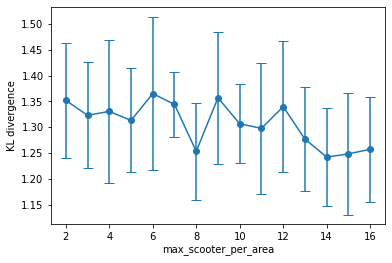

In [102]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

max_scooter_per_area_list = np.arange(2,17)
max_kl_list_grid = [np.array(avg_kl_max_2)[sel_index_2],
                        np.array(avg_kl_max_3)[sel_index_3],
                        np.array(avg_kl_max_4)[sel_index_4],
                        np.array(avg_kl_max_5)[sel_index_5],
                        np.array(avg_kl_max_6)[sel_index_6],
                        np.array(avg_kl_max_7)[sel_index_7],
                        np.array(avg_kl_max_8)[sel_index_8],
                        np.array(avg_kl_max_9)[sel_index_9],
                        np.array(avg_kl_max_10)[sel_index_10],
                        np.array(avg_kl_max_11)[sel_index_11],
                        np.array(avg_kl_max_12)[sel_index_12],
                        np.array(avg_kl_max_13)[sel_index_13],
                        np.array(avg_kl_max_14)[sel_index_14],
                        np.array(avg_kl_max_15)[sel_index_15],
                        np.array(avg_kl_max_16)[sel_index_16]]
max_kl_mean_grid = []
max_kl_std_grid = []
for ii in range(len(max_scooter_per_area_list)):
    max_kl_mean_grid.append(np.mean(max_kl_list_grid[ii]))
    max_kl_std_grid.append(np.std(max_kl_list_grid[ii]))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1 = plt.errorbar(max_scooter_per_area_list, max_kl_mean_grid, yerr=max_kl_std_grid, fmt='o-', capsize=5) # ecolor='gray', 

print("Plotting baseline 1...")
# plt.legend(loc='best',prop={'size': 10})
plt.ylabel("KL divergence")
plt.xlabel("max_scooter_per_area")

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))